# Turbulence Development Over Complex Terrain
This notebook contains the necessary code to analyze the SOWFA simulations that are used to determine the effectiveness of terrain in generating turbulence.

## Import necessary libraries

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sowfadict as sowfa
import tools
from scipy.stats import norm
from scipy.stats import skew,kurtosis
from scipy import signal
import pandas as pd
from matplotlib.colors import Normalize

### Declare user variables (cases, towers, colors, etc.) for tower data

In [96]:
terrstr = 'D2'
simstr  = ['PGx2.2En4_zi1100']*3

caselbl = ['Turb.','Laminar','Pert.']
cases   = ['M2_{}_TurbBC'.format(terrstr),'M2_{}_NoTurbBC'.format(terrstr),'M2_{}_PertBC'.format(terrstr)]
if terrstr == 'SR':
    casec   = ['navy','darkturquoise','blue']
    terrstr_f = 'Complex Terrain'
elif terrstr == 'D2':
    casec   = ['red','goldenrod','darkred']
    terrstr_f = 'Smoothed Terrain'
casece  = [casec[0],'none',casec[2]]#,'none']
casecf  = ['none',casec[1],'none']#,casec[3]]
casem   = ['o','x','+']
caselw  = ['3','2','3','2']
casea   = [0.8,1.0,0.8,1.0]
casesz  = [50,15,50,15]
casels  = ['-',':','--']
ncases  = np.shape(cases)[0]

#simstr  = ['PGx2.2En4_zi550','PGx2.2En4_zi550','PGx2.2En4_zi550']#,'PGx2.2En4_zi550']
x = np.arange(0,101)

varns   = ['u','v','w','T']
nvars   = np.shape(varns)[0]

timedir = 14400

avgstart = 1799 # when do you want to start the averaging?
avgend   = -1 # when do you want to end the averaging?

lvl     = 5

twrs    = np.arange(1,9)
ntwrs   = np.shape(twrs)[0]

lblsize = 14.0
txtsize = 12.0
legsize = 10.0
savedir = '/home/phawbeck/SOWFA/Terrain/img/'


### Load in the data and store for manipulation & plotting

In [97]:
initIndividualTowerVars = True
initAvgTowerVars        = True
for cc in range(0,ncases):
    for tt in range(0,ntwrs):
        fdir      = '/projects/mmc/NWTCRegion/{}/NWTC.run.{}/postProcessing/'.format(simstr[cc],cases[cc])
        pl        = 'probeLine%d' % twrs[tt]
        probeLine = sowfa.probeLine('%s%s/%d/' % (fdir,pl,timedir),'y',['U','T'])
        dt        = np.round(np.mean(probeLine.time[1:] - probeLine.time[:-1]),2)
        ntwr      = probeLine.ntowers; ntwrsq = int(np.sqrt(ntwr))
        if tt == 0: 
            tdz        = np.mean(probeLine.z[0,1:] - probeLine.z[0,:-1]) 
            twrheight  = probeLine.z[0,:] - probeLine.z[0,0] + tdz/2.0
            nz = np.shape(twrheight)[0]
        for vv in range(0,nvars):
            var = varns[vv]
            for tw in np.arange(0,probeLine.ntowers):
                if var == 'u':
                    pvar   = probeLine.u[tw,:,avgstart:avgend]
                    #avgvar = np.mean(probeLine.u[tw,:,avgstart:avgend],axis=1)
                elif var == 'v':
                    pvar   = probeLine.v[tw,:,avgstart:avgend]
                    #avgvar = np.mean(probeLine.v[tw,:,avgstart:avgend],axis=1)
                elif var == 'w':
                    pvar   = probeLine.w[tw,:,avgstart:avgend]
                    #avgvar = np.mean(probeLine.w[tw,:,avgstart:avgend],axis=1)
                elif var == 'T':
                    pvar   = probeLine.T[tw,:,avgstart:avgend]
                    #avgvar = np.mean(probeLine.T[tw,:,avgstart:avgend],axis=1)
                if initIndividualTowerVars == True:
                    print ("initializing individual tower vars")
                    time       = probeLine.time[avgstart:avgend] 
                    ntimes     = np.shape(time)[0]
                    tsvarfull  = np.zeros((nvars,ncases,ntwrs,ntwr,nz,ntimes))
                    initIndividualTowerVars = False
                tsvarfull[vv,cc,tt,tw,:,:]  = pvar
    print ('Done with case: {}'.format(cases[cc]))

initializing individual tower vars
Done with case: M2_D2_TurbBC
Done with case: M2_D2_NoTurbBC
Done with case: M2_D2_PertBC


### Calculate statistics

In [98]:
saveTable = False
vmean     = np.zeros((nvars,ncases,ntwrs))
vvari     = np.zeros((nvars,ncases,ntwrs))
vskew     = np.zeros((nvars,ncases,ntwrs))
vkurt     = np.zeros((nvars,ncases,ntwrs))
for vvi,vv in enumerate(varns):
    varind = varns.index(vv)
    casestr = ['']*ncases*ntwrs
    twrstr  = ['']*ncases*ntwrs

    count = 0
    for cc in range(0,ncases):
        for tt in range(0,ntwrs):
            casestr[count]   = cases[cc]
            twrstr[count]    = twrs[tt]
            #varpfs          = np.sort(varpfull[varind,cc,tt,:])
            varpfs           = tsvarfull[varind,cc,tt,:,lvl,:]
            vmean[vvi,cc,tt] = np.mean(varpfs.flatten())
            vvari[vvi,cc,tt] = np.var(varpfs.flatten()-vmean[vvi,cc,tt])
            vskew[vvi,cc,tt] = skew(varpfs.flatten()-vmean[vvi,cc,tt])
            vkurt[vvi,cc,tt] = kurtosis(varpfs.flatten()-vmean[vvi,cc,tt])
            count += 1
#    df = pd.DataFrame(
#        data={
#            'Case':casestr,
#            'Tower Number':twrstr,
#            'Mean':vmean.flatten(),
#            'Variance':vvari.flatten(),
#            'Skewness':vskew.flatten(),
#            'Kurtosis':vkurt.flatten(),
#        })
#    #df.to_latex('test.tex')
#    df = df[['Case','Tower Number','Mean','Variance','Skewness','Kurtosis']]
#    if saveTable: df.to_latex('{}/SR_{}_statistics.tex'.format(savedir,var))
#    print df

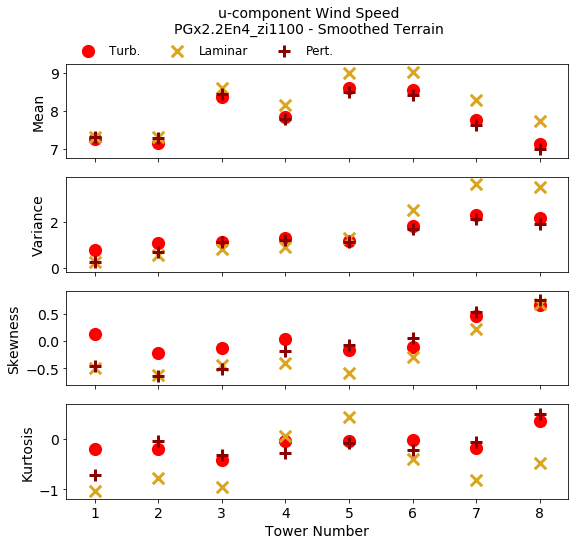

In [99]:
saveFig = True
var = 'u'
varind = varns.index(var)
fig, ax = plt.subplots(nrows=4,ncols=1,figsize=(9,8),sharex=True)
if var == 'T':
    plt.suptitle('Potential Temperature [K]',size=lblsize)
    labelstr = '[K]'
    legloc = 4
else:
    plt.suptitle('{}-component Wind Speed\n{} - {}'.format(var,simstr[0],terrstr_f),size=lblsize)
    labelstr = '[m s$^{-1}$]'
    legloc = (0.01,1.02)

ax[0].tick_params(labelsize=14)
ax[1].tick_params(labelsize=14)
ax[2].tick_params(labelsize=14)
ax[3].tick_params(labelsize=14)
for cc in range(0,ncases):
    lw = 2.0; ms = 125
    if cc > 0: lw = 3.0; ms = 130
    ax[0].scatter(twrs,vmean[varind,cc,:],facecolor=casec[cc],s=ms,marker=casem[cc],lw=lw,label=caselbl[cc])
    ax[1].scatter(twrs,vvari[varind,cc,:],facecolor=casec[cc],s=ms,marker=casem[cc],lw=lw)
    ax[2].scatter(twrs,vskew[varind,cc,:],facecolor=casec[cc],s=ms,marker=casem[cc],lw=lw)
    ax[3].scatter(twrs,vkurt[varind,cc,:],facecolor=casec[cc],s=ms,marker=casem[cc],lw=lw)
ax[0].legend(frameon=False,ncol=ncases,loc=(0.01,1.02),fontsize=12)
ax[0].set_ylabel('Mean',size=14)
ax[1].set_ylabel('Variance',size=14)
ax[2].set_ylabel('Skewness',size=14)
ax[3].set_ylabel('Kurtosis',size=14)
ax[3].set_xlabel('Tower Number',size=14)
if saveFig: 
    plt.savefig('{}{}_{}_Statistics_{}.png'.format(savedir,simstr[cc].replace('.','p'),terrstr,var))
    plt.savefig('{}{}_{}_Statistics_{}.pdf'.format(savedir,simstr[cc].replace('.','p'),terrstr,var))
plt.show()